In [67]:
import os
from collections import Counter
import pandas as pd
import numpy as np

from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, accuracy_score, roc_auc_score, auc, precision_recall_curve, roc_curve

from xgboost import XGBClassifier
import spacy

import time
from tqdm import tqdm
from prettytable import PrettyTable

from sentence_transformers import SentenceTransformer

import tensorflow_hub as hub
import tensorflow as tf

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [68]:
import torch.nn.functional as F
from transformers import EvalPrediction
import transformers
import torch
from transformers import BertTokenizer, BertModel, BertConfig
from datasets import Dataset, ClassLabel
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

In [69]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [70]:
use_embed = hub.load("../supervisée_DL/use/")

In [71]:
tabel = PrettyTable()

tabel.field_names=['Model', 'Precision', 'Recall', 'Jaccard_score', 'f1_score', "Accuracy", 'Experiment title']

result = []

metric_name = "Accuracy"

In [72]:
RANDOM_SEED = 42

# Import the dataset

In [73]:
df = pd.read_parquet('clean_v1.parquet')
df.reset_index(inplace=True, drop=True)

df.sample(15)

Title  \
61085            force jupyter notebook open web browser   
61561  djangooauthtoolkit customize authenticate resp...   
52561                       detail appcrash message mean   
41906                 way export shortcuts visual studio   
56745        appfabric cache perform x slower sql server   
253        certificate invalid issuer apple push service   
3452                 plsql insert subquery return clause   
59571                     kill infinite loop javaclojure   
49397  xcode uilaunchimages deprecate use launch stor...   
51325               wrap manualresetevent awaitable task   
31164      onactivitycreated call onviewcreated fragment   
41607                   advantage use sqlite rather file   
17811                use callable use runnable interface   
61730           importerror module name selenium pycharm   
10530    sql recursive query self reference table oracle   

                                                    Body        Id  \
61085  run jupyter notebooks python remote cluster co...  52210690   
61561  new django oauth toolkit want customize authen...  54370004   
52561  experience appcrash c# application runtime giv...  12922961   
41906  change default shortcuts work want synchronize...  38528945   
56745  run test compare fetch time bw appfabric sql s...  12647232   
253    create certificate enable push service app eve...  35390072   
3452   cannot figure correct syntax follow pseudosql ...   5325033   
59571  responses potential answer sprinkle interrupt ...  10254655   
49397  download xcode beta want build swift project g...  57084407   
51325  would like await manual reset event timeout ob...  18756354   
31164  two viewmodels one use fragment one share view...  56260090   
41607  android enter data sqlite use time line cod tx...  19946298   
17811  quite new java go concepts multithreading go v...  37458703   
61730  instal file package like python pip selenium r...  54760754   
10530  let us assume sample data name id parentid nul...   2319284   

                                                    Tags  Score  ViewCount  \
61085                                         python ssh     22      15302   
61561                                      python django      6       4118   
52561                                                 c#      7       4247   
41906                                      visual-studio     35       6732   
56745                                     c# performance      8       4192   
253                                            ios xcode    477     143640   
3452                                          sql oracle     28      55133   
59571                                java multithreading      6       3305   
49397                                                ios     35      28637   
51325  c# .net multithreading task-parallel-library a...     47      28685   
31164                                            android     12       7810   
41607                                     android sqlite     16      15594   
17811                                               java      8       3173   
61730      python python-3.x selenium selenium-webdriver      6      19181   
10530                                sql database oracle     35     112084   

       AnswerCount  FavoriteCount  \
61085            3            0.0   
61561            3            0.0   
52561            4            0.0   
41906            1            0.0   
56745            3            0.0   
253             14            0.0   
3452             5            0.0   
59571            4            0.0   
49397            4            0.0   
51325            5            0.0   
31164            2            0.0   
41607            2            0.0   
17811            5            0.0   
61730            3            0.0   
10530            5            0.0   

                                         Title_not_clean  \
61085  force jupyter notebook *not* to open a web bro...   
61561  

# Utility function

In [74]:
def most_tags(dataframes : any, nbr_tags: int = 50):
    dataframe = dataframes.copy()
    cnt = Counter()
    for text in dataframe["Tags"].values:
        cnt[text] += 1
        for word in text.split(): #
            cnt[word] += 1
    tag_counts = pd.DataFrame(cnt.most_common(), columns=["Word", "Freq"]).sort_values(['Freq'], ascending=False)

    tags_kept = list(tag_counts['Word'].head(nbr_tags))

    print(f"Number of tags kept : {len(tags_kept)}")
    print(f"Top ten tags  : {tags_kept[:10]}")
    for le in tqdm(range(dataframe.shape[0])):
        a = []
        b = dataframe['Tags'][le].split(" ")

        for i in range(len(b)):
            for j in tags_kept:
                temp = b[i].strip()  #Stripping the white-spaces present(if any) around the tag
                if temp == j:
                    a.append(j)
        if a:
            dataframe.loc[le, 'Tags'] = " ".join(a)
        else:
            dataframe.loc[le, 'Tags'] = np.nan
    dataframe = dataframe.dropna()
    print(f"New df dims : {dataframe.shape}", "-"*100, sep="\n")
    return dataframe


def scoring_metrics(model : any, exp_title : str, test_data: any, val : any, proba : bool, threshold : float = 0.50):
    model_name = "LinearSVC" if model.estimator.__class__.__name__ == "CalibratedClassifierCV" else model.estimator.__class__.__name__
    if proba:
        exp_title = exp_title + f" (seuil : {str(threshold)})"
        prediction = model.predict_proba(val)
        prediction = np.where(prediction > threshold, 1, 0)
    else:
        prediction = model.predict(val)
    precision = round(precision_score(test_data, prediction, average='micro'), 2)
    recall = round(recall_score(test_data, prediction, average='micro'), 2)
    jaccard = round(jaccard_score(test_data, prediction, average='micro'), 2)
    accuracy = round(accuracy_score(test_data, prediction), 2)
    f1 = round(f1_score(test_data, prediction, average='micro'), 2)
    tabel.add_row([model_name, precision, recall, jaccard, f1, accuracy, exp_title])
    # print(f"model : {model_name}, precision: {precision}, recall: {recall}, jaccard_score : {jaccard}, F1-measure: {f1}, accuracy : {accuracy}")
    return model_name, precision, recall, jaccard, f1, accuracy, exp_title

In [152]:
def my_argmax(a):
    # Test function to return multiple indices not just the first
    rows = np.where(a == a.max(axis=1)[:, None])[0]
    rows_multiple_max = rows[:-1][rows[:-1] == rows[1:]]
    my_argmax = a.argmax(axis=1)
    my_argmax[rows_multiple_max] = -1
    return my_argmax

def best_model(train_data, test_data, multilabel, model, plot_cm :bool=False, plot_roc :bool=False):
    clf = OneVsRestClassifier(model)
    clf.fit(train_data, y_train)
    target_names = multilabel.classes_
    index = np.random.randint(0, test_data.shape[0])
    y_pred = clf.predict_proba(test_feature)
    # check the proba output
    print(f"Probability output : {y_pred[index]}", "-"*100, sep="\n")

    y_pred = np.where(y_pred >= .50, 1, 0)

    print(classification_report(test_data, y_pred, target_names=target_names))
    print("*"*100,
          f"Row index number : {index}", f"Nber of empty tags : {test_data.shape[0] - y_pred[~(y_pred == 0).all(axis= 1)].shape[0]} !",
          f"Real tags : {multilabel.inverse_transform(test_data)[index]}",
          f"Predicted tags :{multilabel.inverse_transform(y_pred)[index]}",
          "*"*100, sep="\n")
    if plot_cm:
        # Plot Cm
        cm = confusion_matrix(test_data.argmax(axis=1), y_pred.argmax(axis=1)) # can't do multi label -> argmax
        fig, ax = plt.subplots(figsize=(10,6))
        sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
                    cbar=False)
        ax.set(xlabel="Pred", ylabel="True", xticklabels=target_names,
               yticklabels=target_names, title="Confusion matrix")
        plt.yticks(rotation=0)
        plt.xticks(rotation=0)
        plt.show()
    if plot_roc:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
        ## Plot roc
        for i in range(len(target_names)):
            fpr, tpr, thresholds = roc_curve(y_test[:,i],
                                             y_pred[:,i])
            ax[0].plot(fpr, tpr, lw=3#, label=f"{target_names} (area={auc(fpr, tpr)})"
                       )
        ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
        ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],
                  xlabel='False Positive Rate',
                  ylabel="True Positive Rate (Recall)",
                  title="Receiver operating characteristic")
        # ax[0].legend(loc="lower right")
        ax[0].grid(True)

        ## Plot precision-recall curve
        for i in range(len(target_names)):
            precision, recall, thresholds = precision_recall_curve(
                test_data[:,i], y_pred[:,i])
            ax[1].plot(recall, precision, lw=3, label=f"{target_names[i]} (area={auc(recall, precision)})"
                       )
        ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',
                  ylabel="Precision", title="Precision-Recall curve")
        # ax[1].legend(loc="best")
        ax[1].grid(True)
        fig.legend(fontsize=6, loc="upper right")
        plt.show()

In [76]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [77]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average = 'micro')
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'jaccard': jaccard,
               'recall': recall,
               'precision': precision
               }
    return metrics

def compute_metrics(p: EvalPrediction):
    # Transformers function for the trainer
    preds = p.predictions[0] if isinstance(p.predictions,
                                           tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result


# Preprocessing and sanity check

In [78]:
# getting most relevant tags
data = most_tags(df, 20)

Number of tags kept : 20
Top ten tags  : ['c#', 'java', 'python', 'javascript', 'c++', 'android', 'ios', '.net', 'php', 'html']


100%|██████████| 62669/62669 [00:07<00:00, 7957.08it/s]

New df dims : (47451, 10)
----------------------------------------------------------------------------------------------------


In [79]:
# making sure that each classe are represented at least two times
data.drop(
    data[data['Tags'].isin(data['Tags'].value_counts().loc[lambda x: x <= 2].reset_index()['index'].tolist())].index,
    inplace=True)

In [80]:
# sanity control that title and body doesn't have empty rows
data.drop(
    data[data["Title"] == ''].index,
    inplace=True)

data.drop(
    data[data["Body"] == ''].index,
    inplace=True)

In [81]:
data.reset_index(inplace=True, drop=True)

In [82]:
data.describe(include=[object])

Title  \
count                           47349   
unique                          47329   
top     django equivalent count group   
freq                                2   

                                                     Body    Tags  \
count                                               47349   47349   
unique                                              47349     192   
top     program application objectivec get error myapp...  python   
freq                                                    1    5450   

                                    Title_not_clean  \
count                                         47349   
unique                                        47344   
top     java.lang.outofmemoryerror: java heap space   
freq                                              2   

                                           Body_not_clean  
count                                               47349  
unique                                              47349  
top     i'm programming an application in objective-c ...  
freq                                                    1

In [83]:
data["Tags"].value_counts()

python                       5450
java                         5427
c#                           3934
c++                          3455
javascript                   2988
                             ... 
php jquery html                 3
android ios iphone              3
javascript php html mysql       3
c# html asp.net                 3
c# android ios                  3
Name: Tags, Length: 192, dtype: int64

In [84]:
data["Tags"].apply(lambda text: len(str(text).split(" "))).describe()

count    47349.000000
mean         1.281822
std          0.548743
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: Tags, dtype: float64

In [85]:
data.shape

(47349, 10)

# Different algorithm used for training

In [86]:
algos = [LogisticRegression(n_jobs=-1, random_state=RANDOM_SEED, max_iter=400),
         CalibratedClassifierCV(LinearSVC(random_state=RANDOM_SEED, max_iter=10_000)), # Must use CalibratedClassifierCV to get probability output
         SGDClassifier(n_jobs=-1, loss="modified_huber", random_state=RANDOM_SEED),
         SGDClassifier(n_jobs=-1, loss="log_loss", random_state=RANDOM_SEED),
         XGBClassifier(random_state=RANDOM_SEED, tree_method='gpu_hist')]

In [87]:
mlb = MultiLabelBinarizer()
X = data["Title"]
y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
print(X.shape, y.shape)

(47349,) (47349, 20)


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=data['Tags'])
print(f"Train size : {X_train.shape, y_train.shape}, test size : {X_test.shape, y_test.shape}")

Train size : ((35511,), (35511, 20)), test size : ((11838,), (11838, 20))


# Bag of words
** First test will be to fit and title and transform title + body
** Test result with and without predict_proba

## Only title

### CountVectorizer on title

In [23]:
cv_vector = CountVectorizer(ngram_range=(1, 1))
cv_vector.fit(X_train)
train_feature = cv_vector.transform(X_train + " " + data.loc[X_train.index]['Body'])
test_feature = cv_vector.transform(X_test + " " + data.loc[X_test.index]['Body'])
print(train_feature.shape, test_feature.shape)

(35511, 18285) (11838, 18285)


In [24]:
exp_title = "Sac de mots simple, CountVectorizer : title"

print(exp_title)
for algo in tqdm(algos):
    # if algo == algos[0]: # To avoid convergence warning LogReg
    #     algo = LogisticRegression(n_jobs=-1, random_state=RANDOM_SEED, max_iter=400)
    # if algo == algos[1]: # To avoid convergence warning SVM
    #     algo = CalibratedClassifierCV(LinearSVC(random_state=RANDOM_SEED, max_iter=10_000))
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, False)
    result.append(score)
tab_idx = len(tabel.rows)
print(tabel[:tab_idx].get_string(sortby=metric_name, reversesort=True))

Sac de mots simple, CountVectorizer : title


100%|██████████| 5/5 [02:07<00:00, 25.53s/it]

+--------------------+-----------+--------+---------------+----------+----------+---------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |               Experiment title              |
+--------------------+-----------+--------+---------------+----------+----------+---------------------------------------------+
|   XGBClassifier    |    0.84   |  0.65  |      0.58     |   0.73   |   0.53   | Sac de mots simple, CountVectorizer : title |
| LogisticRegression |    0.77   |  0.66  |      0.55     |   0.71   |   0.51   | Sac de mots simple, CountVectorizer : title |
|   SGDClassifier    |    0.78   |  0.63  |      0.54     |   0.7    |   0.49   | Sac de mots simple, CountVectorizer : title |
|     LinearSVC      |    0.87   |  0.46  |      0.43     |   0.6    |   0.42   | Sac de mots simple, CountVectorizer : title |
|   SGDClassifier    |    0.64   |  0.63  |      0.46     |   0.63   |   0.4    | Sac de mots simple, Co

In [25]:
exp_title = "Sac de mots simple, CountVectorizer : title"

print(exp_title)

for algo in tqdm(algos):
    # if algo == algos[0]: # To avoid convergence warning LogReg
    #     algo = LogisticRegression(n_jobs=-1, random_state=RANDOM_SEED, max_iter=400)
    # if algo == algos[1]: # To avoid convergence warning SVM
    #     algo = CalibratedClassifierCV(LinearSVC(random_state=RANDOM_SEED, max_iter=10_000))
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots simple, CountVectorizer : title


100%|██████████| 5/5 [02:15<00:00, 27.15s/it]

+--------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |                      Experiment title                     |
+--------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------+
|   XGBClassifier    |    0.84   |  0.65  |      0.58     |   0.73   |   0.53   | Sac de mots simple, CountVectorizer : title (seuil : 0.5) |
| LogisticRegression |    0.77   |  0.66  |      0.55     |   0.71   |   0.51   | Sac de mots simple, CountVectorizer : title (seuil : 0.5) |
|   SGDClassifier    |    0.78   |  0.63  |      0.54     |   0.7    |   0.49   | Sac de mots simple, CountVectorizer : title (seuil : 0.5) |
|     LinearSVC      |    0.87   |  0.46  |      0.43     |   0.6    |   0.42   | Sac de mots simple, CountVectorizer : title (seuil : 0.5) |
|   SG

In [26]:
cv_vector = CountVectorizer(ngram_range=(1, 2))
cv_vector.fit(X_train)
train_feature = cv_vector.transform(X_train + " " + data.loc[X_train.index]['Body'])
test_feature = cv_vector.transform(X_test + " " + data.loc[X_test.index]['Body'])
print(train_feature.shape, test_feature.shape)

(35511, 130310) (11838, 130310)


In [27]:
exp_title = "Sac de mots ngram_range=(1, 2), CountVectorizer : title"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots ngram_range=(1, 2), CountVectorizer : title


100%|██████████| 5/5 [03:40<00:00, 44.10s/it]

+--------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |                            Experiment title                           |
+--------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------------------+
|   XGBClassifier    |    0.85   |  0.65  |      0.58     |   0.74   |   0.54   | Sac de mots ngram_range=(1, 2), CountVectorizer : title (seuil : 0.5) |
| LogisticRegression |    0.81   |  0.64  |      0.56     |   0.72   |   0.52   | Sac de mots ngram_range=(1, 2), CountVectorizer : title (seuil : 0.5) |
|   SGDClassifier    |    0.8    |  0.62  |      0.54     |   0.7    |   0.49   | Sac de mots ngram_range=(1, 2), CountVectorizer : title (seuil : 0.5) |
|     LinearSVC      |    0.87   |  0.54  |      0.5      |   0.66   |   0.4

** On peut constater qu'en fixant un seuil de proba sur nos sorties, on augmente légèrement nos résultats **

In [28]:
# print(tabel[:tab_idx].get_string(sortby=metric_name, reversesort=True))

In [29]:
# best_model(y_test, mlb, XGBClassifier())

### TfidfVectorizer on title

In [30]:
tfidf_vector = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vector.fit(X_train)
train_feature = tfidf_vector.transform(X_train + " " + data.loc[X_train.index]['Body'])
test_feature = tfidf_vector.transform(X_test + " " + data.loc[X_test.index]['Body'])
print(train_feature.shape, test_feature.shape)

(35511, 18285) (11838, 18285)


In [31]:
exp_title = "Sac de mots simple, TfidfVectorizer : title"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)

print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots simple, TfidfVectorizer : title


100%|██████████| 5/5 [00:42<00:00,  8.49s/it]

+--------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |                      Experiment title                     |
+--------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------+
|     LinearSVC      |    0.85   |  0.64  |      0.57     |   0.73   |   0.54   | Sac de mots simple, TfidfVectorizer : title (seuil : 0.5) |
|   SGDClassifier    |    0.86   |  0.6   |      0.55     |   0.71   |   0.52   | Sac de mots simple, TfidfVectorizer : title (seuil : 0.5) |
| LogisticRegression |    0.87   |  0.51  |      0.47     |   0.64   |   0.44   | Sac de mots simple, TfidfVectorizer : title (seuil : 0.5) |
|   SGDClassifier    |    0.89   |  0.35  |      0.33     |   0.5    |   0.31   | Sac de mots simple, TfidfVectorizer : title (seuil : 0.5) |
|   XG

In [89]:
tfidf_vector = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vector.fit(X_train)
train_feature = tfidf_vector.transform(X_train + " " + data.loc[X_train.index]['Body'])
test_feature = tfidf_vector.transform(X_test + " " + data.loc[X_test.index]['Body'])
print(train_feature.shape, test_feature.shape)

(35511, 130310) (11838, 130310)


In [33]:
exp_title = "Sac de mots ngram_range=(1, 2), TfidfVectorizer : title"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots ngram_range=(1, 2), TfidfVectorizer : title


100%|██████████| 5/5 [01:20<00:00, 16.15s/it]

+--------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |                            Experiment title                           |
+--------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------------------------------+
|     LinearSVC      |    0.84   |  0.66  |      0.59     |   0.74   |   0.55   | Sac de mots ngram_range=(1, 2), TfidfVectorizer : title (seuil : 0.5) |
|   SGDClassifier    |    0.87   |  0.59  |      0.55     |   0.71   |   0.51   | Sac de mots ngram_range=(1, 2), TfidfVectorizer : title (seuil : 0.5) |
| LogisticRegression |    0.87   |  0.49  |      0.46     |   0.63   |   0.42   | Sac de mots ngram_range=(1, 2), TfidfVectorizer : title (seuil : 0.5) |
|   SGDClassifier    |    0.9    |  0.31  |      0.3      |   0.47   |   0.2

In [128]:
# Linear SVC got the best results let's check the quality of the predictions
best_model(train_feature, test_feature, mlb, algos[1])

Probability output : [1.46409116e-02 3.45665553e-05 2.35448798e-03 9.48324851e-03
 6.42167156e-02 2.96009902e-03 7.49051554e-04 2.61955076e-03
 9.37045752e-01 9.71692669e-01 1.10961329e-04 1.71360416e-03
 8.65634322e-04 1.68976582e-03 1.74361573e-03 3.72600132e-01
 3.05011567e-03 1.44498914e-03 8.98859574e-04 3.04471882e-03]
----------------------------------------------------------------------------------------------------
224737


ValueError: Classification metrics can't handle a mix of continuous-multioutput and multilabel-indicator targets

## Title + body

### CountVectorizer title + body

In [34]:
mlb = MultiLabelBinarizer()
X = data["Title"] + " " + data["Body"]
y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
print(X.shape, y.shape)

(47349,) (47349, 20)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED,
                                                    stratify=data['Tags'])
print(f"Train size : {X_train.shape, y_train.shape}, test size : {X_test.shape, y_test.shape}")

Train size : ((35511,), (35511, 20)), test size : ((11838,), (11838, 20))


In [36]:
cv_vector = CountVectorizer(ngram_range=(1, 1))
cv_vector.fit(X_train)
train_feature = cv_vector.transform(X_train)
test_feature = cv_vector.transform(X_test)
print(train_feature.shape, test_feature.shape)

(35511, 241663) (11838, 241663)


In [37]:
exp_title = "Sac de mots simple, CountVectorizer : title + body"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots simple, CountVectorizer : title + body


100%|██████████| 5/5 [06:22<00:00, 76.46s/it] 

+--------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |                         Experiment title                         |
+--------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------+
|   XGBClassifier    |    0.84   |  0.65  |      0.58     |   0.73   |   0.54   | Sac de mots simple, CountVectorizer : title + body (seuil : 0.5) |
| LogisticRegression |    0.79   |  0.65  |      0.56     |   0.72   |   0.52   | Sac de mots simple, CountVectorizer : title + body (seuil : 0.5) |
|   SGDClassifier    |    0.79   |  0.63  |      0.54     |   0.7    |   0.49   | Sac de mots simple, CountVectorizer : title + body (seuil : 0.5) |
|     LinearSVC      |    0.86   |  0.49  |      0.45     |   0.62   |   0.43   | Sac de mots simple, Coun

In [38]:
cv_vector = CountVectorizer(ngram_range=(1, 2))
cv_vector.fit(X_train)
train_feature = cv_vector.transform(X_train)
test_feature = cv_vector.transform(X_test)
print(train_feature.shape, test_feature.shape)

(35511, 1600743) (11838, 1600743)


In [39]:
exp_title = "Sac de mots ngram_range=(1, 2), CountVectorizer : title + body"

print(exp_title)

for algo in tqdm(algos[:4]): # skip XGB OOM cuda ! too much dims to compute !!!
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots ngram_range=(1, 2), CountVectorizer : title + body


100%|██████████| 4/4 [04:39<00:00, 69.92s/it] 

+--------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |                               Experiment title                               |
+--------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------------------+
| LogisticRegression |    0.83   |  0.62  |      0.56     |   0.71   |   0.51   | Sac de mots ngram_range=(1, 2), CountVectorizer : title + body (seuil : 0.5) |
|   SGDClassifier    |    0.82   |  0.62  |      0.55     |   0.71   |   0.5    | Sac de mots ngram_range=(1, 2), CountVectorizer : title + body (seuil : 0.5) |
|     LinearSVC      |    0.86   |  0.56  |      0.51     |   0.68   |   0.48   | Sac de mots ngram_range=(1, 2), CountVectorizer : title + body (seuil : 0.5) |
|   SGDClassifier    |    0.72   |

### CountVectorizer title + body

In [40]:
tfidf_vector = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vector.fit(X_train)
train_feature = tfidf_vector.transform(X_train)
test_feature = tfidf_vector.transform(X_test)
print(train_feature.shape, test_feature.shape)

(35511, 241663) (11838, 241663)


In [41]:
exp_title = "Sac de mots simple, TfidfVectorizer : title + body"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots simple, TfidfVectorizer : title + body


100%|██████████| 5/5 [01:49<00:00, 21.85s/it]

+--------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |                         Experiment title                         |
+--------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------+
|     LinearSVC      |    0.83   |  0.68  |      0.6      |   0.75   |   0.56   | Sac de mots simple, TfidfVectorizer : title + body (seuil : 0.5) |
|   SGDClassifier    |    0.86   |  0.62  |      0.57     |   0.72   |   0.53   | Sac de mots simple, TfidfVectorizer : title + body (seuil : 0.5) |
| LogisticRegression |    0.86   |  0.53  |      0.49     |   0.66   |   0.45   | Sac de mots simple, TfidfVectorizer : title + body (seuil : 0.5) |
|   SGDClassifier    |    0.88   |  0.37  |      0.35     |   0.52   |   0.32   | Sac de mots simple, Tfid

In [66]:
tfidf_vector = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vector.fit(X_train)
train_feature = tfidf_vector.transform(X_train)
test_feature = tfidf_vector.transform(X_test)
print(train_feature.shape, test_feature.shape)

NameError: name 'X_train' is not defined

In [43]:
exp_title = "Sac de mots ngram_range=(1, 2), TfidfVectorizer : title + body"

print(exp_title)

for algo in tqdm(algos[:4]): # OOM with XGBClassifier
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Sac de mots ngram_range=(1, 2), TfidfVectorizer : title + body


100%|██████████| 4/4 [02:37<00:00, 39.42s/it] 

+--------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |                               Experiment title                               |
+--------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------------------------------+
|     LinearSVC      |    0.79   |  0.74  |      0.62     |   0.76   |   0.56   | Sac de mots ngram_range=(1, 2), TfidfVectorizer : title + body (seuil : 0.5) |
|   SGDClassifier    |    0.86   |  0.61  |      0.55     |   0.71   |   0.51   | Sac de mots ngram_range=(1, 2), TfidfVectorizer : title + body (seuil : 0.5) |
| LogisticRegression |    0.85   |  0.48  |      0.44     |   0.61   |   0.4    | Sac de mots ngram_range=(1, 2), TfidfVectorizer : title + body (seuil : 0.5) |
|   SGDClassifier    |    0.9    |

Probability output : [5.11323626e-04 6.03525724e-05 6.55814531e-04 6.33785845e-04
 2.81123443e-05 4.28167217e-03 1.62441665e-04 1.38060161e-04
 3.35068732e-01 3.20982639e-01 6.37548886e-05 1.97010441e-01
 2.82001189e-04 2.46849605e-03 6.52044142e-04 7.48050505e-01
 4.06353187e-04 9.73605182e-04 1.63278341e-04 3.82751519e-04]
----------------------------------------------------------------------------------------------------
(11838, 1)
(9651, 20)
               precision    recall  f1-score   support

         .net       0.64      0.28      0.38       781
      android       0.95      0.88      0.91       907
      asp.net       0.82      0.53      0.65       335
            c       0.72      0.48      0.57       503
           c#       0.78      0.59      0.67      1680
          c++       0.83      0.65      0.73      1089
          css       0.85      0.72      0.78       471
         html       0.69      0.48      0.57       601
          ios       0.83      0.71      0.77       919

/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


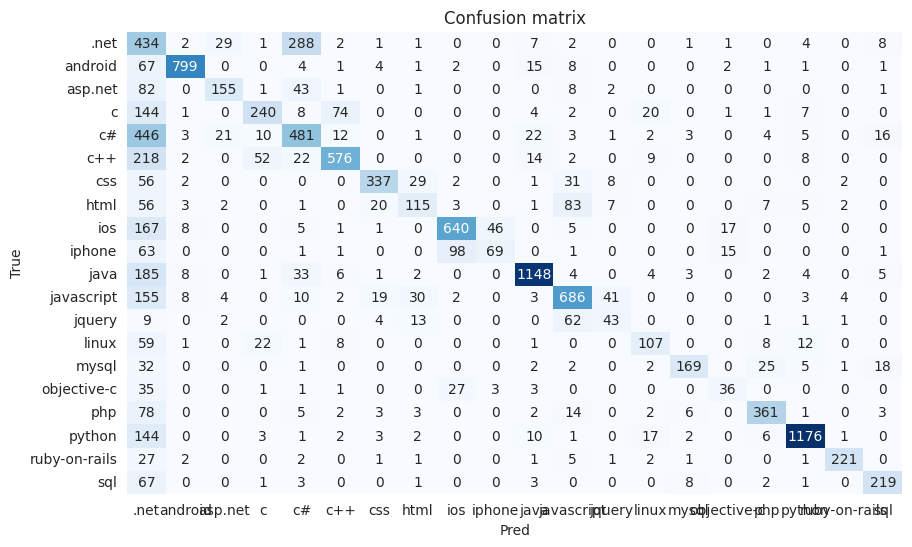

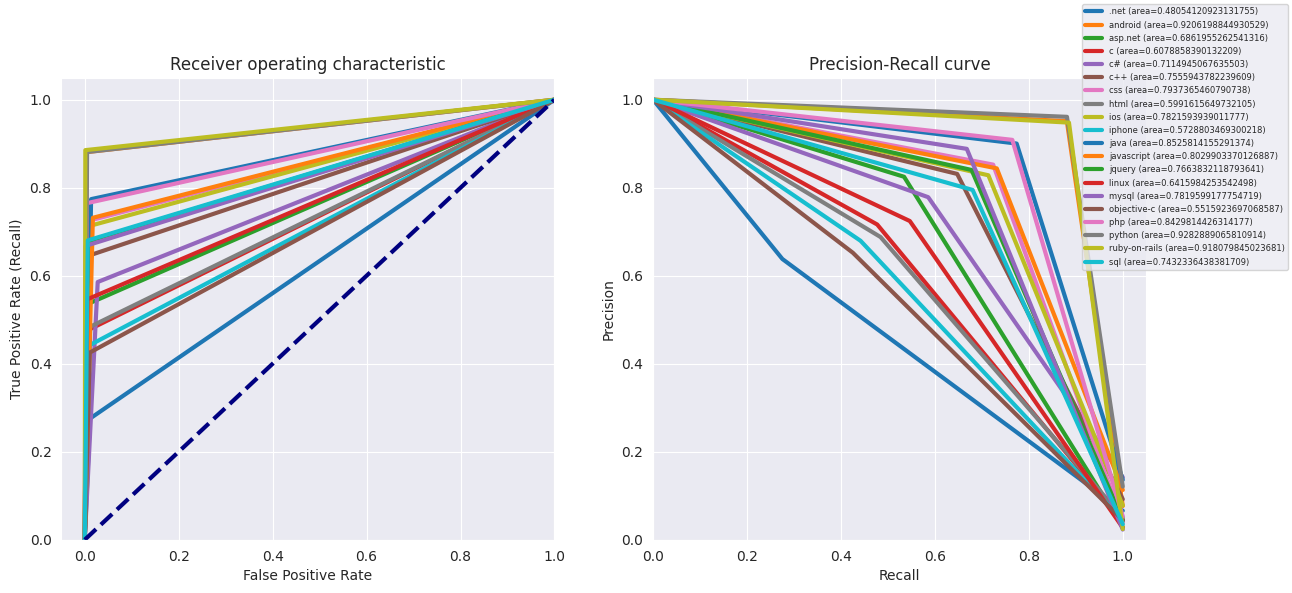

In [153]:
# Linear SVC got the best results let's check the quality of the predictions
best_model(train_feature, y_test, mlb, algos[1], True, True)

# Test with TruncatedSVD to reduce the number of dims

In [45]:
n_comp = 500
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), TruncatedSVD(n_components=n_comp))
pipe.fit(X_train)

train_feature = pipe.transform(X_train)
test_feature = pipe.transform(X_test)
print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (35511, 500), test size : (11838, 500)


In [46]:
exp_title = f"Truncated SVD ({n_comp} dim) : title + body"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Truncated SVD (500 dim) : title + body


100%|██████████| 5/5 [01:45<00:00, 21.13s/it]

+--------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |                   Experiment title                   |
+--------------------+-----------+--------+---------------+----------+----------+------------------------------------------------------+
|     LinearSVC      |    0.79   |  0.66  |      0.57     |   0.72   |   0.5    | Truncated SVD (500 dim) : title + body (seuil : 0.5) |
|   SGDClassifier    |    0.82   |  0.57  |      0.51     |   0.67   |   0.46   | Truncated SVD (500 dim) : title + body (seuil : 0.5) |
|   XGBClassifier    |    0.83   |  0.53  |      0.48     |   0.65   |   0.45   | Truncated SVD (500 dim) : title + body (seuil : 0.5) |
| LogisticRegression |    0.84   |  0.46  |      0.42     |   0.6    |   0.38   | Truncated SVD (500 dim) : title + body (seuil : 0.5) |
|   SGDClassifier    |    0.88   |  0.25 

In [47]:
n_comp = 1000
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), TruncatedSVD(n_components=n_comp))
pipe.fit(X_train)

train_feature = pipe.transform(X_train)
test_feature = pipe.transform(X_test)
print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (35511, 1000), test size : (11838, 1000)


In [48]:
exp_title = f"Truncated SVD ({n_comp} dim) : title + body"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

Truncated SVD (1000 dim) : title + body


100%|██████████| 5/5 [03:00<00:00, 36.15s/it]

+--------------------+-----------+--------+---------------+----------+----------+-------------------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |                    Experiment title                   |
+--------------------+-----------+--------+---------------+----------+----------+-------------------------------------------------------+
|     LinearSVC      |    0.8    |  0.68  |      0.58     |   0.74   |   0.53   | Truncated SVD (1000 dim) : title + body (seuil : 0.5) |
|   SGDClassifier    |    0.84   |  0.59  |      0.53     |   0.69   |   0.48   | Truncated SVD (1000 dim) : title + body (seuil : 0.5) |
|   XGBClassifier    |    0.83   |  0.52  |      0.47     |   0.64   |   0.44   | Truncated SVD (1000 dim) : title + body (seuil : 0.5) |
| LogisticRegression |    0.85   |  0.47  |      0.44     |   0.61   |   0.39   | Truncated SVD (1000 dim) : title + body (seuil : 0.5) |
|   SGDClassifier    |    0.9    |

# Optimizing BOW with gridsearch

In [49]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(CalibratedClassifierCV(LinearSVC(random_state=RANDOM_SEED, max_iter=10_000)))),
])
parameters = [{
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__max_features': (None, 5000, 10000, 50000),
    'tfidf__ngram_range': ((1, 1), (1, 2), (1,3)),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2', None),
    # 'clf__estimator__loss': ("modified_huber", 'log_loss', "hinge")
}]

grid_search = GridSearchCV(pipeline, parameters, scoring="f1_micro", n_jobs=-1, cv=5, refit=True)

In [50]:
# grid_search.fit(X_train, y_train)

In [51]:
# grid_search.best_score_

In [52]:
# grid_search.best_params_

In [53]:
# grid_search.best_estimator_

In [54]:
# prediction = grid_search.best_estimator_.predict(X_test)
# precision = round(precision_score(y_test, prediction, average='weighted'), 2)
# recall = round(recall_score(y_test, prediction, average='weighted'), 2)
# jaccard = round(jaccard_score(y_test, prediction, average='weighted'), 2)
# accuracy = round(accuracy_score(y_test, prediction), 2)
# f1 = round(f1_score(y_test, prediction, average='weighted'), 2)
# print(f"model : test, precision: {precision}, recall: {recall}, jaccard_score : {jaccard}, F1-measure: {f1}, acc : {accuracy}")

In [ ]:
# Linear SVC got the best results let's check the quality of the predictions
# best_model(train_feature, test_feature, mlb, algos[1])

# Doc2vec Gensim

In [55]:
mlb = MultiLabelBinarizer()
X = data["Title"] + " " + data["Body"]
y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED,
                                                    stratify=data['Tags'])
print(f"Train size : {X_train.shape, y_train.shape}, test size : {X_test.shape, y_test.shape}")

(47349,) (47349, 20)
Train size : ((35511,), (35511, 20)), test size : ((11838,), (11838, 20))


In [56]:
card_docs = [TaggedDocument(doc.split(' '), [i])
             for i, doc in enumerate(X_train)]

model = Doc2Vec(vector_size=300, window=5, min_count=1, workers=8, epochs=50)

model.build_vocab(card_docs)

model.train(card_docs, total_examples=model.corpus_count
            , epochs=model.epochs)

In [57]:
train_vec = [model.infer_vector((X_train.to_list()[i].split(' ')))
             for i in range(0, len(X_train))]

train_feature = np.array(train_vec)

test_vec = [model.infer_vector((X_test.to_list()[i].split(' ')))
            for i in range(0, len(X_test))]

test_feature = np.array(test_vec)
print(train_feature.shape, test_feature.shape)

(35511, 300) (11838, 300)


In [58]:
exp_title = "doc2vec : title + body clean"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

doc2vec : title + body clean


 20%|██        | 1/5 [00:15<01:00, 15.23s/it]/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

+--------------------+-----------+--------+---------------+----------+----------+--------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |              Experiment title              |
+--------------------+-----------+--------+---------------+----------+----------+--------------------------------------------+
|   XGBClassifier    |    0.78   |  0.33  |      0.3      |   0.46   |   0.28   | doc2vec : title + body clean (seuil : 0.5) |
|     LinearSVC      |    0.46   |  0.75  |      0.4      |   0.57   |   0.26   | doc2vec : title + body clean (seuil : 0.5) |
| LogisticRegression |    0.41   |  0.78  |      0.37     |   0.54   |   0.22   | doc2vec : title + body clean (seuil : 0.5) |
|   SGDClassifier    |    0.39   |  0.78  |      0.35     |   0.52   |   0.2    | doc2vec : title + body clean (seuil : 0.5) |
|   SGDClassifier    |    0.32   |  0.75  |      0.29     |   0.45   |   0.14   | doc2vec : title + body clean 

# More advanced NLP techniques

## USE (universal sentence encoder)

In [59]:
mlb = MultiLabelBinarizer()
X = data["Title_not_clean"] + " . " + data["Body_not_clean"]
y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED,
                                                    stratify=data['Tags'])
print(f"Train size : {X_train.shape, y_train.shape}, test size : {X_test.shape, y_test.shape}")

(47349,) (47349, 20)
Train size : ((35511,), (35511, 20)), test size : ((11838,), (11838, 20))


In [60]:
train_feature = []
for r in tqdm(X_train):

    emb = use_embed([r])
    review_emb = tf.reshape(emb, [-1]).numpy()
    train_feature.append(review_emb)

train_feature = np.array(train_feature)
test_feature = []
for r in tqdm(X_test):
    emb = use_embed([r])
    review_emb = tf.reshape(emb, [-1]).numpy()
    test_feature.append(review_emb)

test_feature = np.array(test_feature)
print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

100%|██████████| 11838/11838 [00:10<00:00, 1136.00it/s]

Train size : (35511, 512), test size : (11838, 512)


In [61]:
exp_title = "use : title + body not clean"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

use : title + body not clean


100%|██████████| 5/5 [01:42<00:00, 20.50s/it]

+--------------------+-----------+--------+---------------+----------+----------+--------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |              Experiment title              |
+--------------------+-----------+--------+---------------+----------+----------+--------------------------------------------+
|   XGBClassifier    |    0.83   |  0.7   |      0.61     |   0.76   |   0.58   | use : title + body not clean (seuil : 0.5) |
|   SGDClassifier    |    0.83   |  0.7   |      0.61     |   0.76   |   0.58   | use : title + body not clean (seuil : 0.5) |
|     LinearSVC      |    0.83   |  0.71  |      0.62     |   0.77   |   0.58   | use : title + body not clean (seuil : 0.5) |
| LogisticRegression |    0.84   |  0.68  |      0.6      |   0.75   |   0.56   | use : title + body not clean (seuil : 0.5) |
|   SGDClassifier    |    0.85   |  0.62  |      0.56     |   0.72   |   0.52   | use : title + body not clean 

In [ ]:
#  XGBClassifier got the best results let's check the quality of the predictions
best_model(train_feature, test_feature, mlb, algos[4])

## Sentence transformer Bert

In [62]:
mlb = MultiLabelBinarizer()
X = data["Title_not_clean"] + " . " + data["Body_not_clean"]
y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED,
                                                    stratify=data['Tags'])
print(f"Train size : {X_train.shape, y_train.shape}, test size : {X_test.shape, y_test.shape}")

(47349,) (47349, 20)
Train size : ((35511,), (35511, 20)), test size : ((11838,), (11838, 20))


### Lightest Bert sentence transformer

In [63]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
train_feature = model.encode(X_train.tolist(), output_value='sentence_embedding', convert_to_numpy=True, normalize_embeddings=False)
test_feature = model.encode(X_test.tolist(), output_value='sentence_embedding', convert_to_numpy=True, normalize_embeddings=False)

print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (35511, 384), test size : (11838, 384)


In [64]:
exp_title = "all-MiniLM-L6-v2 : DL not clean"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

all-MiniLM-L6-v2 : DL not clean


100%|██████████| 5/5 [01:32<00:00, 18.42s/it]

+--------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |                Experiment title               |
+--------------------+-----------+--------+---------------+----------+----------+-----------------------------------------------+
|     LinearSVC      |    0.85   |  0.74  |      0.65     |   0.79   |   0.62   | all-MiniLM-L6-v2 : DL not clean (seuil : 0.5) |
|   SGDClassifier    |    0.86   |  0.71  |      0.64     |   0.78   |   0.61   | all-MiniLM-L6-v2 : DL not clean (seuil : 0.5) |
| LogisticRegression |    0.85   |  0.72  |      0.64     |   0.78   |   0.59   | all-MiniLM-L6-v2 : DL not clean (seuil : 0.5) |
|   XGBClassifier    |    0.86   |  0.68  |      0.61     |   0.76   |   0.58   | all-MiniLM-L6-v2 : DL not clean (seuil : 0.5) |
|   SGDClassifier    |    0.86   |  0.68  |      0.61     |   0.76   |   0.58   | all-Mini

## Heavy sentence transformer model

In [65]:
model = SentenceTransformer('all-mpnet-base-v2')
train_feature = model.encode(X_train.tolist(), output_value='sentence_embedding', convert_to_numpy=True, normalize_embeddings=False)
test_feature = model.encode(X_test.tolist(), output_value='sentence_embedding', convert_to_numpy=True, normalize_embeddings=False)

print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (35511, 768), test size : (11838, 768)


In [66]:

exp_title = "all-mpnet-base-v2 : DL not clean"

print(exp_title)

for algo in tqdm(algos):
    clf = OneVsRestClassifier(algo)
    clf.fit(train_feature, y_train)
    score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
    result.append(score)
print(tabel[tab_idx:].get_string(sortby=metric_name, reversesort=True))
tab_idx = len(tabel.rows)

all-mpnet-base-v2 : DL not clean


100%|██████████| 5/5 [02:11<00:00, 26.36s/it]

+--------------------+-----------+--------+---------------+----------+----------+------------------------------------------------+
|       Model        | Precision | Recall | Jaccard_score | f1_score | Accuracy |                Experiment title                |
+--------------------+-----------+--------+---------------+----------+----------+------------------------------------------------+
|     LinearSVC      |    0.86   |  0.77  |      0.69     |   0.81   |   0.65   | all-mpnet-base-v2 : DL not clean (seuil : 0.5) |
|   SGDClassifier    |    0.87   |  0.74  |      0.67     |   0.8    |   0.64   | all-mpnet-base-v2 : DL not clean (seuil : 0.5) |
| LogisticRegression |    0.86   |  0.75  |      0.67     |   0.8    |   0.63   | all-mpnet-base-v2 : DL not clean (seuil : 0.5) |
|   XGBClassifier    |    0.87   |  0.71  |      0.64     |   0.78   |   0.61   | all-mpnet-base-v2 : DL not clean (seuil : 0.5) |
|   SGDClassifier    |    0.87   |  0.71  |      0.64     |   0.78   |   0.6    | a

In [ ]:
#  SVC got the best results let's check the quality of the predictions
best_model(train_feature, test_feature, mlb, algos[1], True, True)

### Specific version trained on NER or code

In [67]:
# model = SentenceTransformer('microsoft/codebert-base')
# train_feature = model.encode(X_train.tolist())
# test_feature = model.encode(X_test.tolist())
#
# print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

In [68]:
# exp_title = "microsoft/codebert-base : DL not clean"
#
# print(exp_title)
#
# for algo in algos:
#     clf = OneVsRestClassifier(algo)
#     clf.fit(train_feature, y_train)
#     score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
#     result.append(score)

In [69]:
# model = SentenceTransformer('jeniya/BERTOverflow')
# train_feature = model.encode(X_train.tolist())
# test_feature = model.encode(X_test.tolist())
#
# print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

In [70]:
# exp_title = "jeniya/BERTOverflow : DL not clean"
#
# print(exp_title)
#
# for algo in algos:
#     clf = OneVsRestClassifier(algo)
#     clf.fit(train_feature, y_train)
#     score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
#     result.append(score)

# test

In [71]:
# mlb = MultiLabelBinarizer()
# X = data["Title_not_clean"] #+ " . " + data["Body"]
# y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
# print(X.shape, y.shape)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED,
#                                                     stratify=data['Tags'])
# print(f"Train size : {X_train.shape, y_train.shape}, test size : {X_test.shape, y_test.shape}")

In [72]:
# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# train_feature = model.encode(X_train.tolist())
# test_feature = model.encode(X_test.tolist())
#
# print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

In [73]:
# exp_title = "sentence-transformers/all-MiniLM-L6-v2 : DL clean title"
#
# print(exp_title)
#
# for algo in tqdm(algos):
#     clf = OneVsRestClassifier(algo)
#     clf.fit(train_feature, y_train)
#     score = scoring_metrics(clf, exp_title, y_test, test_feature, True)
#     result.append(score)

In [74]:
df_result = pd.DataFrame(result,
                         columns=['Model', 'Precision', 'Recall', 'Jaccard_score', 'f1_score', 'Accuracy', 'Experiment_title'])
df_result.to_csv("res_all_v2_20.csv", index=False)

# Train a bert model for sequence classification

In [44]:
mlb = MultiLabelBinarizer()
X = pd.DataFrame(data["Title_not_clean"] + " . " + data["Body_not_clean"], columns=["DL_not_clean"])
y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
print(X.shape, y.shape)

(47349, 1) (47349, 20)


### Transforming the dataset into transformers object Dataset

In [45]:
temp_y = pd.DataFrame(y, columns=mlb.classes_.tolist())
transform_df = pd.concat([X, temp_y], axis=1)
transform_df.reset_index(inplace=True, drop=True)
train, test = train_test_split(transform_df, test_size=0.25, random_state=RANDOM_SEED, stratify=data['Tags'])

In [46]:
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)
# Removing index from pandas df
train_dataset = train_dataset.remove_columns(["__index_level_0__"])
test_dataset = test_dataset.remove_columns(["__index_level_0__"])

In [47]:
# format the labels
labels = [label for label in train_dataset.features.keys() if label not in ['DL_not_clean']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

## Test with classic Bert (lighter version)

In [48]:
model_id = "distilbert-base-uncased" #"mrm8488/codebert-base-finetuned-stackoverflow-ner" #""
train_batch_size = 8
val_batch_size = 3
metric_name = "f1"
num_epoch = 5

In [49]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

loading configuration file config.json from cache at /home/alex/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /home/alex/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /home/alex/.cache/huggingface/hub/models--distilbert-base

In [50]:
def preprocess_data(examples):
    # take a batch of texts
    text = examples["DL_not_clean"]
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]
    # To match what the model input accepts
    encoding["labels"] = labels_matrix.tolist()

    return encoding

In [51]:
encoded_dataset_train = train_dataset.map(preprocess_data, batched=True, remove_columns=[col for col in train_dataset.features.keys()])
encoded_dataset_test = test_dataset.map(preprocess_data, batched=True, remove_columns=[col for col in test_dataset.features.keys()])
encoded_dataset_train.set_format("torch")
encoded_dataset_test.set_format("torch")

Map:   0%|          | 0/35511 [00:00<?, ? examples/s]

Map:   0%|          | 0/11838 [00:00<?, ? examples/s]

In [ ]:
example = encoded_dataset_train[100]
print(example.keys())

In [ ]:
tokenizer.decode(example['input_ids'])

In [52]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

loading configuration file config.json from cache at /home/alex/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": ".net",
    "1": "android",
    "2": "asp.net",
    "3": "c",
    "4": "c#",
    "5": "c++",
    "6": "css",
    "7": "html",
    "8": "ios",
    "9": "iphone",
    "10": "java",
    "11": "javascript",
    "12": "jquery",
    "13": "linux",
    "14": "mysql",
    "15": "objective-c",
    "16": "php",
    "17": "python",
    "18": "ruby-on-rails",
    "19": "sql"
  },
  "initializer_range": 0.02,
  "label2id": {
    ".net": 0,
    "android": 1,
    "asp.net": 2,
    "c": 3,
    "c#": 4,
    "c++": 5,
    "css": 6,
    "html": 7,
    "ios": 8,
    "i

In [53]:
args = TrainingArguments(
    f"bert-finetuned-classif-stack-overflow",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=val_batch_size,
    num_train_epochs=num_epoch,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [54]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset_train,
    eval_dataset=encoded_dataset_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 35511
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22195
  Number of trainable parameters = 66968852
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


***** Running Evaluation *****
  Num examples = 11838
  Batch size = 3
Saving model checkpoint to bert-finetuned-classif-stack-overflow/checkpoint-4439
Configuration saved in bert-finetuned-classif-stack-overflow/checkpoint-4439/config.json
Model weights saved in bert-finetuned-classif-stack-overflow/checkpoint-4439/pytorch_model.bin
tokenizer config file saved in bert-finetuned-classif-stack-overflow/checkpoint-4439/tokenizer_config.json
Special tokens file saved in bert-finetuned-classif-stack-overflow/checkpoint-4439/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 11838
  Batch size = 3
Saving model checkpoint to bert-finetuned-classif-stack-overflow/checkpoint-17756
Configuration saved in bert-finetuned-classif-stack-overflow/checkpoint-17756/config.json
Model weights saved in bert-finetuned-classif-stack-overflow/checkpoint-17756/pytorch_model.bin
tokenizer config file saved in bert-finetuned-classif-stack-overflow/checkpoint-17756/tokenizer_config.json
Spe

TrainOutput(global_step=22195, training_loss=0.04846877836917912, metrics={'train_runtime': 4900.7047, 'train_samples_per_second': 36.231, 'train_steps_per_second': 4.529, 'total_flos': 2.35277990728704e+16, 'train_loss': 0.04846877836917912, 'epoch': 5.0})

In [61]:
res = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 11838
  Batch size = 3


In [65]:
res

{'eval_loss': 0.05886947363615036,
 'eval_f1': 0.8285224637924662,
 'eval_roc_auc': 0.9012265149789516,
 'eval_accuracy': 0.6839837810440953,
 'eval_jaccard': 0.7072457116631289,
 'eval_recall': 0.8126565589980224,
 'eval_precision': 0.8450202207142368,
 'eval_runtime': 100.8168,
 'eval_samples_per_second': 117.421,
 'eval_steps_per_second': 39.14,
 'epoch': 5.0}

In [63]:
torch.cuda.empty_cache()

In [ ]:
result.append(model_id, res["eval_precision"], res["eval_recall"], res["eval_jaccard"], res["eval_f1"], res["eval_accuracy"], "Distilbert model")

In [ ]:
# trainer.save_model("./my_model")
# model = AutoModelForSequenceClassification.from_pretrained(path)

In [ ]:
# text = "I'm happy I can finally train a model for multi-label classification in sk-learn"
#
# encoding = tokenizer(text, return_tensors="pt")
# encoding = {k: v.to(trainer.model.device) for k, v in encoding.items()}
#
# outputs = trainer.model(**encoding)
# logits = outputs.logits
# # logits.shape
# #
# # # apply sigmoid + threshold
# # sigmoid = torch.nn.Sigmoid()
# # probs = sigmoid(logits.squeeze().cpu())
# # predictions = np.zeros(probs.shape)
# # predictions[np.where(probs >= 0.5)] = 1
# # probs
#
# # apply sigmoid + threshold
# sigmoid = torch.nn.Sigmoid()
# probs = sigmoid(logits.squeeze().cpu())
# predictions = np.zeros(probs.shape)
# predictions[np.where(probs >= 0.5)] = 1
# # turn predicted id's into actual label names
# predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
# print(predicted_labels)

In [ ]:
# df_result = pd.DataFrame(result,
#                          columns=['Model', 'Precision', 'Recall', 'Jaccard_score', 'f1_score', 'Accuracy', 'Experiment_title'])
# df_result.to_csv("res_all_v1_25.csv", index=False)